In [1]:
import numpy as np
import matplotlib.pyplot as plt

from coffea import util, hist


In [2]:
outputMC = util.load('ttgammaMC.coffea')
outputData = util.load('ttgammaData.coffea')

In [3]:
grouping= {'ttgamma': ['TTGamma_Dilepton','TTGamma_SingleLept','TTGamma_Hadronic'],
           'ttbar'  : ['TTbarPowheg_Dilepton', 'TTbarPowheg_Semilept', 'TTbarPowheg_Hadronic'],
           'Single top':['ST_s_channel', 'ST_tW_channel', 'ST_tbarW_channel', 'ST_tbar_channel', 'ST_t_channel'],
           'Wgamma' : ['WGamma_01J_5f'],
           'Zgamma' : ['ZGamma_01J_5f_lowMass'],
           'Other'    : ['TTWtoLNu','TTWtoQQ','TTZtoLL','W1jets', 'W2jets', 'W3jets', 'W4jets','DYjetsM10to50', 'DYjetsM50','GJets_HT40To100', 'GJets_HT100To200', 'GJets_HT200To400', 'GJets_HT400To600', 'GJets_HT600ToInf', 'QCD_Pt20to30_Ele', 'QCD_Pt30to50_Ele', 'QCD_Pt50to80_Ele', 'QCD_Pt80to120_Ele', 'QCD_Pt120to170_Ele', 'QCD_Pt170to300_Ele', 'QCD_Pt300toInf_Ele', 'QCD_Pt20to30_Mu', 'QCD_Pt30to50_Mu', 'QCD_Pt50to80_Mu', 'QCD_Pt80to120_Mu', 'QCD_Pt120to170_Mu', 'QCD_Pt170to300_Mu', 'QCD_Pt300to470_Mu', 'QCD_Pt470to600_Mu', 'QCD_Pt600to800_Mu', 'QCD_Pt800to1000_Mu', 'QCD_Pt1000toInf_Mu']
          }


In [4]:
h = outputMC['M3'].sum('lepFlavor').sum('M3').group('dataset',hist.Cat(r'dataset',r'Samples'),grouping)
h = h.rebin('category',hist.Bin('category',r"Photon Category",[1,2,3,5]))

In [5]:
vals = h.values()
mcYield = []
for s in vals:
    mcYield.append(vals[s])
mcYield = np.array(mcYield)

errs = h._sumw2
mcYieldErr = []
for s in errs:
    mcYieldErr.append(errs[s][1:4]**0.5)
mcYieldErr = np.array(mcYieldErr)

In [6]:
misIDEleSF = 2.1
WGammaSF = 1.2
ZGammaSF = 1.05

mcYield[:,1] *= misIDEleSF
mcYieldErr[:,1] *= misIDEleSF

mcYield[3] *= WGammaSF
mcYieldErr[3] *= WGammaSF

mcYield[4] *= ZGammaSF
mcYieldErr[4] *= ZGammaSF


In [7]:
print(mcYield)

print(mcYieldErr)

[[5.56633841e+03 1.22183036e+01 5.86736213e+01]
 [1.12446158e+02 7.68644137e+02 1.28489836e+03]
 [3.85338879e+02 2.38013252e+01 6.05248694e+01]
 [1.82031840e+02 0.00000000e+00 1.35358155e+00]
 [1.97274287e+02 8.35469681e-01 1.24528015e+00]
 [4.53167507e+02 1.69008183e+02 1.35290735e+02]]
[[ 12.90693506   0.6586112    1.33137819]
 [  2.52741151   8.54140707  11.48352856]
 [  9.21600012   3.55572423   3.70133481]
 [ 15.9953448    0.           1.35358155]
 [  8.88303697   0.83546968   0.71903087]
 [194.19563926  20.50564518  34.74202914]]


In [8]:
def getPseudoData(mcYield, mcYieldErr, ttgammaSF=1., npSF=1., asimov=False):
    mcYieldTest = mcYield.copy()
    mcYieldTest[0] *=  ttgammaSF
    mcYieldTest[:,2] *= npSF
    
    if not asimov:
        mcYieldTest = np.random.poisson(mcYieldTest)

    photonPurity = mcYieldTest[:,:2].sum()/mcYieldTest.sum()
    photonPurityErr = 0.04

    topPurity = mcYieldTest[:2].sum()/mcYieldTest.sum()
    topPurityErr = 0.02

    nData = mcYieldTest.sum()

    return photonPurity, photonPurityErr, topPurity, topPurityErr, nData


In [9]:
#import numba

def likelihoodFunction(ttgammaSF=1., nonPromptSF=1., mcValues=None, mcValuesErr=None, photonPurity=None, topPurity=None, nData = None, photonPurityErr=None, topPurityErr=None):
    mcValues[0] *= ttgammaSF
    mcValuesErr[0] *= ttgammaSF

    mcValues[:,-1] *= nonPromptSF
    mcValuesErr[:,-1] *= nonPromptSF
    
    nMC = mcValues.sum()
    nMCErr = (mcValuesErr**2).sum()**0.5

    #nIso is the sum of the first two columsn of data (genuine and misID)
    nIso = mcValues[:,0:2].sum()
    nIsoErr = (mcValuesErr[:,0:2]**2).sum()**0.5

    #nTop is the sum of the first two rows (ttgamma and ttbar)
    nTop = mcValues[0:2].sum()
    nTopErr = (mcValuesErr[0:2]**2).sum()**0.5

    mcPhotonPurity    = nIso/nMC
    mcPhotonPurityErr = (mcPhotonPurity) * ((nIsoErr/nIso)**2 + (nMCErr/nMC)**2)**0.5

    mcTopPurity = nTop/nMC
    mcTopPurityErr = mcTopPurity * ((nTopErr/nTop)**2 + (nMCErr/nMC)**2)**0.5
    
    
    chi2 = ((photonPurity-mcPhotonPurity)**2/(photonPurityErr**2 + mcPhotonPurityErr**2) + 
            (topPurity - mcTopPurity)**2/(topPurityErr**2 + mcTopPurityErr**2) +
            (nData - nMC)**2/(nData + nMCErr**2)
           )
    
    return np.exp(-0.5*chi2)
                
    

In [10]:
def maximizeLikelihood(fitData, 
                       ttgSF = None, nonPromptSF=None, 
                       startTTGamma = 1., startNonprompt = 1., 
                       nSteps = 100,
                       verbose=False, 
                       find1sigma = False, 
                       nStepsErr = 20):


    mcYield=fitData['mcYield']
    mcYieldErr=fitData['mcYieldErr']
    photonPurity=fitData['photonPurity']
    photonPurityErr=fitData['photonPurityErr']
    topPurity=fitData['topPurity']
    topPurityErr=fitData['topPurityErr']
    nData=fitData['nData']
    
    
    if ttgSF is None:
        ttgSF=startTTGamma
        iTTGSteps = range(3)
    else:
        iTTGSteps = [1]

    if nonPromptSF is None:
        nonPromptSF=startNonprompt
        iNPSteps = range(3)
    else:
        iNPSteps = [1]
        
    stepSize = 0.1
    
    lastStepLk = -1.

    for steps in range(nSteps):

        best_lk = -1
        best_iTTG = -1
        best_iNP = -1
        
        for iTTG in iTTGSteps:
            for iNP in iNPSteps:
                lk = likelihoodFunction(ttgammaSF = ttgSF + (iTTG-1)*stepSize , 
                                        nonPromptSF=nonPromptSF + (iNP-1)*stepSize, 
                                        mcValues=mcYield.copy(), mcValuesErr=mcYieldErr.copy(),
                                        photonPurity=photonPurity, topPurity=topPurity, 
                                        photonPurityErr=photonPurityErr, topPurityErr=topPurityErr, 
                                        nData=nData)

                if lk > best_lk:
                    best_lk = lk
                    best_iTTG = iTTG
                    best_iNP = iNP

        ttgSF = ttgSF+(best_iTTG-1)*stepSize
        nonPromptSF = nonPromptSF + (best_iNP-1)*stepSize

        if best_iTTG==best_iNP==1:
            stepSize = stepSize/2.
            lastStepLk=-1.

        if verbose:
            print(steps, ttgSF, nonPromptSF, stepSize, best_lk)
            
    if find1sigma:

        ### scan for ttgSF down
        ttgammaErr = 0.1
        stepSize = 0.1
        trend = 1
        for step in range(nStepsErr):
            _,_,_lk = maximizeLikelihood(fitData, 
                                         ttgSF = ttgSF - ttgammaErr, 
                                         nonPromptSF=None, 
                                         nSteps = 50,
                                    )


            NLL = -2*np.log(_lk/best_lk)

            if NLL < 1:
                if trend== -1:
                    stepSize /= 2.
                ttgammaErr += stepSize
                trend=1
            else:
                if trend==1:
                    stepSize /= 2.
                ttgammaErr -= stepSize
                trend=-1
        ttgammaDown = -1*ttgammaErr

        ### scan for ttgSF up
        ttgammaErr = 0.1
        stepSize = 0.1
        trend = 1
        for step in range(nStepsErr):
            _,_,_lk = maximizeLikelihood(fitData, 
                                         ttgSF = ttgSF + ttgammaErr, 
                                         nonPromptSF=None, 
                                         nSteps = 50,
                                        )

            NLL = -2*np.log(_lk/best_lk)

            if NLL < 1:
                if trend== -1:
                    stepSize /= 2.
                ttgammaErr += stepSize
                trend=1
            else:
                if trend==1:
                    stepSize /= 2.
                ttgammaErr -= stepSize
                trend=-1
        ttgammaUp = ttgammaErr

        ### scan for npSF down
        npErr = 0.1
        stepSize = 0.1
        trend = 1
        for step in range(nStepsErr):
            _,_,_lk = maximizeLikelihood(fitData, 
                                         ttgSF = None, 
                                         nonPromptSF=nonPromptSF - npErr, 
                                         nSteps = 50,
                                        )            

            NLL = -2*np.log(_lk/best_lk)

            if NLL < 1:
                if trend== -1:
                    stepSize /= 2.
                npErr += stepSize
                trend=1
            else:
                if trend==1:
                    stepSize /= 2.
                npErr -= stepSize
                trend=-1
        nonPromptDown = -1*npErr

        ### scan for npSF up        
        npErr = 0.1
        stepSize = 0.1
        trend = 1
        for step in range(nStepsErr):
            _,_,_lk = maximizeLikelihood(fitData, 
                                         ttgSF = None, 
                                         nonPromptSF=nonPromptSF + npErr,
                                         nSteps = 50,                                         
                                        )            

            NLL = -2*np.log(_lk/best_lk)

            if NLL < 1:
                if trend== -1:
                    stepSize /= 2.
                npErr += stepSize
                trend=1
            else:
                if trend==1:
                    stepSize /= 2.
                npErr -= stepSize
                trend=-1
        nonPromptUp = npErr        
        
        return ttgSF, ttgammaUp, ttgammaDown, nonPromptSF, nonPromptUp, nonPromptDown, best_lk
        
    else:
        return ttgSF, nonPromptSF, best_lk


In [11]:
photonPurity, photonPurityErr, topPurity, topPurityErr, nData = getPseudoData(mcYield, 
                                                                              mcYieldErr, 
                                                                              ttgammaSF=1., 
                                                                              npSF = 1.)

In [12]:
fitData = {
    'mcYield':mcYield, 
    'mcYieldErr':mcYieldErr,
    'photonPurity':photonPurity, 
    'photonPurityErr':photonPurityErr, 
    'topPurity':topPurity, 
    'topPurityErr':topPurityErr, 
    'nData':nData, 
}

In [13]:
output = maximizeLikelihood(fitData,
                            nSteps=100, 
                            find1sigma=True, 
                            nStepsErr=100, 
                            startTTGamma=1,
                            startNonprompt=1
                           )
bestTTGSF, bestTTGSF_Up, bestTTGSF_Down, bestNPSF, bestNPSF_Up, bestNPSF_Down, mxLk = output                                                                                                         
print("TTGamma SF = %.4f +%.4f %.4f"%(bestTTGSF, bestTTGSF_Up, bestTTGSF_Down))
print("nonPrompt SF = %.4f +%.4f %.4f"%(bestNPSF, bestNPSF_Up, bestNPSF_Down))
      

TTGamma SF = 1.0072 +0.0863 -0.0847
nonPrompt SF = 0.9738 +0.2927 -0.2936


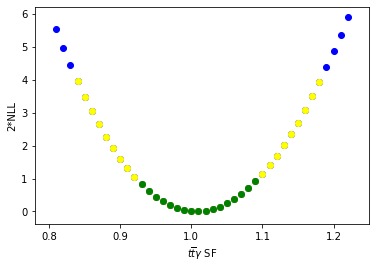

In [14]:
lkVals = []
ttgVals = np.arange(0,2.,.01)
for ttgSF in ttgVals:
    _ttg, _np, _lk = maximizeLikelihood(fitData, ttgSF = ttgSF, nSteps=50)
    lkVals.append(-2*np.log(_lk/mxLk))

lkVals = np.array(lkVals)

plt.scatter(ttgVals[lkVals<6],lkVals[lkVals<6],color='blue')
plt.scatter(ttgVals[lkVals<4],lkVals[lkVals<4],color='yellow')
plt.scatter(ttgVals[lkVals<1],lkVals[lkVals<1],color='green')
plt.ylabel("2*NLL")
plt.xlabel("$t\overline{t}\gamma$ SF")

ttgVals2Sig = ttgVals[lkVals<5]




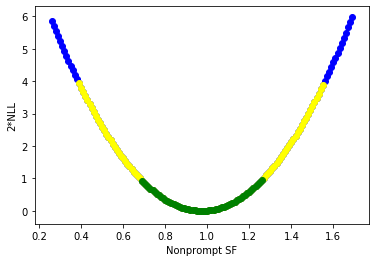

In [15]:
lkVals = []
npVals = np.arange(0,2.,.01)
for npSF in npVals:
    _ttg, _np, _lk = maximizeLikelihood(fitData, nonPromptSF= npSF, nSteps=50)
    lkVals.append(-2*np.log(_lk/mxLk))

lkVals = np.array(lkVals)

plt.scatter(npVals[lkVals<6],lkVals[lkVals<6],color='blue')
plt.scatter(npVals[lkVals<4],lkVals[lkVals<4],color='yellow')
plt.scatter(npVals[lkVals<1],lkVals[lkVals<1],color='green')
plt.ylabel("2*NLL")
plt.xlabel("Nonprompt SF")

npVals2Sig = npVals[lkVals<5]




In [16]:
lkVals = []
for npSF in npVals2Sig:
    _lkVals = []
    for ttg in ttgVals2Sig:
        _ttg, _np, _lk = maximizeLikelihood(fitData, ttgSF= ttg, nonPromptSF= npSF, nSteps=1)
        _lkVals.append(-2*np.log(_lk/mxLk))
    lkVals.append(_lkVals)
lkVals = np.array(lkVals)

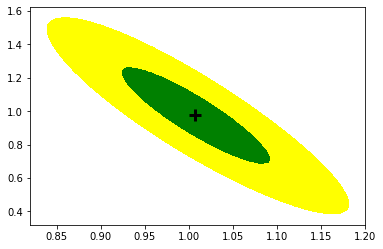

In [17]:
plt.contourf(ttgVals2Sig, npVals2Sig, lkVals, [0,1,4],colors=['green','yellow'])
plt.plot(bestTTGSF, bestNPSF,marker='+',color='black',markersize=12,markeredgewidth=3);
